In [0]:
# 
# This file contains intermediate debiased modeling work used for the 
#   2022 Machine Learning Workshop (part of the Software Symposium)!
#   https://FORWARD_SITE/mlworkshop2022 
#      OR https://INFO_SITE/cdo/events/internal-events/4354c5db-3d3d-4481-97c4-8ad8f12686f1
#
# You can (and should) change them for your own experiments, but they are uniquely defined
# here for constants that we will use together.


# Let's Make "NYC Taxi 2025"!
<img src='https://images.pexels.com/photos/5648421/pexels-photo-5648421.jpeg?auto=compress&cs=tinysrgb&w=640&h=427&dpr=2' width='300px' title="no more 'hailing' with preemptive taxis" />

## Review
* In the first notebook (**01_explore_data**) we looked at NYC Taxi data and regional demographic data.
   * We found that NYC T&LC's geospatial groupings ("zones") worked well for location aggregation.
   * We found and grouped demographics by zones and found there are some potential biases to deal with
* As a reminder, your code will default to the _'beginner'_ path.  As a testament to your _'expertness'_ you can 
  edit the configuration file (`utilities/settings.py`) to set this variable.  *(HINT: Look for EXPERIENCED_MODE)*
* [Image source](https://www.pexels.com/photo/unrecognizable-black-man-catching-taxi-on-city-road-5648421/)


In [0]:
%run ../features/location_ops

In [0]:
%run ../features/taxi_dataset

Credentials not detected, creating a new one (name 'CREDENTIALS' is not defined)...
Detected User ID: ez2685

# Problem Definition
The first part of our worked focused on core CDS responsibilities.   This notebook will look at ways to 
change your raw data and learned ML classifiers.  

*NOTE:* For a quantitative review of our progress, we will be training a light ML model, but the principles
for bias mitigation still apply evenif you're just workingn from an XLS spreadsheet!

Let's create some features!  From the raw ride data, we know that we have location, time, 
and cost information.  We've alreaady handled location information, so let's think about how to
represent time and cost metrics.
* Day part - instead of specific minutes or hours, let's look at more general day parts
* Weekend or weekday - behaviors may change according to these parts of the week
* Distance travelled - compute this from the specific lat/long coordinates
* Expense of the fare - there's still that data problem (check out the previous notebook) that we need to solve for
* (location zone) - also include the mapped "zone" for the features now that we're chosen them

Date Range: 2009-01-01 00:00:00 - 2016-06-30 00:00:00 (total days 2738)
Total Rides: 60930576
Avg Fare: 12.796258857297481

dataset,date_earliest,date_latest,date_count
validate,2013-07-02T00:00:00.000+0000,2014-12-30T00:00:00.000+0000,12176287
test,2014-12-31T00:00:00.000+0000,2016-06-30T00:00:00.000+0000,10654383
train,2009-01-01T00:00:00.000+0000,2013-07-01T00:00:00.000+0000,38102022


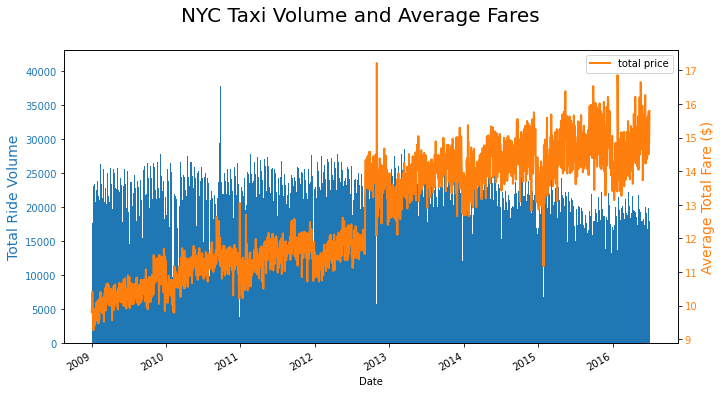

In [0]:
# load geometry for zip codes and filter for NEW YORK state; 
df_shape_tlc = spark.read.format('delta').load(CREDENTIALS['paths']['geometry_nyctaxi'])

# path for cleaned stats
path_stats = CREDENTIALS['paths']['nyctaxi_stats_cleaned']
path_read = CREDENTIALS['paths']['nyctaxi_geo_sampled']

# only admins write this one (it takes almost 10m to aggregate)
if False and CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:  
    # encode the cells (to match zones)
    df_tlc_cells = shape_encode_h3cells(df_shape_tlc, ['zone'], CREDENTIALS['constants']['RESOLUTION_H3'], 'the_geom')

    # load taxi data that has h3 coordinates --- NOTE, we're loading RAW files...
    df_taxi_encoded = spark.read.format('delta').load(CREDENTIALS['paths']['nyctaxi_h3'])  # has h3

    # repair missing data (e.g. missing h3, copy from the valid one if available)
    df_taxi_indexed = (df_taxi_encoded
        .withColumn('dropoff_h3', F.when(F.col('dropoff_h3').isNull() & F.col('pickup_h3').isNotNull(), F.col('pickup_h3'))
                                  .otherwise(F.col('dropoff_h3')))
        .withColumn('pickup_h3', F.when(F.col('pickup_h3').isNull() & F.col('dropoff_h3').isNotNull(), F.col('dropoff_h3'))
                                  .otherwise(F.col('pickup_h3')))
    )

    ### --- these are parts from the first notebook ---- 
    
    # join for both the pick-up and drop off
    df_taxi_indexed = (
        point_intersect_h3cells(df_taxi_indexed.withColumnRenamed('pickup_h3', 'h3'),   # temp rename
                                'pickup_latitude', 'pickup_longitude', 
                                CREDENTIALS['constants']['RESOLUTION_H3'], df_tlc_cells, col_h3='h3')
        .withColumnRenamed('zone', 'pickup_zone')   # rename merged zip
        .withColumnRenamed('h3', 'pickup_h3')   # fix rename and drop extra
    )
    df_taxi_indexed = (
        point_intersect_h3cells(df_taxi_indexed.withColumnRenamed('dropoff_h3', 'h3'),   # temp rename
                                'dropoff_latitude', 'dropoff_longitude', 
                                CREDENTIALS['constants']['RESOLUTION_H3'], df_tlc_cells, col_h3='h3')
        .withColumnRenamed('zone', 'dropoff_zone')   # rename merged zip
        .withColumnRenamed('h3', 'dropoff_h3')    # fix rename and drop extra
    )

    ### --- now we're adding new features ---- 
    
    # generate featurs
    df_taxi_indexed = (df_taxi_indexed
        # .filter(F.col('total_amount').isNull())
        .withColumn('date_trunc', F.date_trunc('day', F.col('pickup_datetime')))   # add simple date column
        .withColumn('ride_hash', F.hash('pickup_datetime', 'pickup_h3'))
        # fill in the total fare 
        .withColumn('total_amount', F.when(F.col('total_amount').isNotNull() & (F.col('total_amount') >= F.col('fare_amount')), 
                                           F.col('total_amount'))
                                    .otherwise(F.col('tolls_amount') + F.col('tip_amount')
                                              + F.col('mta_tax') + F.col('extra') + F.col('fare_amount')))
        .withColumn('has_toll', F.when(F.col('tolls_amount').isNotNull() & (F.col('tolls_amount')>F.lit(0.0)), F.lit(1))
                                .otherwise(F.lit(0)))
        # encode trip duration 
        .withColumn('ride_duration', (F.col("dropoff_datetime").cast('int')) 
                                      - F.col("pickup_datetime").cast('int'))
        # encode into hour parts
        .withColumn('pickup_hour', F.hour(F.col('pickup_datetime')))
        .withColumn('pickup_daypart', 
                    F.when(F.col('pickup_hour') < F.lit(5), 'twilight')  # 12a-5a
                    .when(F.col('pickup_hour') < F.lit(10), 'morning')  # 5a-10a
                    .when(F.col('pickup_hour') < F.lit(15), 'lunch')  # 10a-3p
                    .when(F.col('pickup_hour') < F.lit(18), 'afternoon')  # 3p-6p
                    .when(F.col('pickup_hour') < F.lit(23), 'night')  # 6p-11p
                    .otherwise('twilight'))  # 11p-12a
        .withColumn('dropoff_hour', F.hour(F.col('dropoff_datetime')))
        .withColumn('dropoff_daypart', 
                    F.when(F.col('dropoff_hour') < F.lit(5), 'twilight')  # 12a-5a
                    .when(F.col('dropoff_hour') < F.lit(10), 'morning')  # 5a-10a
                    .when(F.col('dropoff_hour') < F.lit(15), 'lunch')  # 10a-3p
                    .when(F.col('dropoff_hour') < F.lit(18), 'afternoon')  # 3p-6p
                    .when(F.col('dropoff_hour') < F.lit(23), 'night')  # 6p-11p
                    .otherwise('twilight'))  # 11p-12a
        # encode into day of week
        .withColumn('day_of_week', F.dayofweek(F.col('pickup_datetime')))
        .withColumn('weekpart', 
                    F.when((F.col('day_of_week')==F.lit(1)) & (F.col('day_of_week')==F.lit(7)), 'weekend')  # Sun, Sat
                    .when((F.col('day_of_week')==F.lit(6)) & (F.col('pickup_daypart')==F.lit('night')), 'weekend')  # Friday + night
                    .otherwise('weekday'))  # all other times
        # encode into longer term, like month and week of year
        .withColumn('month_of_year', F.month(F.col('pickup_datetime')))
        .withColumn('week_of_year', F.weekofyear(F.col('pickup_datetime')))
        # drop bad data
        .dropna(subset=['pickup_zone', 'dropoff_zone'])
        # drop extra columns
        .drop('vendor_id', 'dropoff_datetime', 'pickup_latitude', 'pickup_longitude',
              'rate_code_id', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 
              'extra', 'mata_tax', 'tolls_amount')
        # finally, reapply the filter
        .sample(CREDENTIALS['constants']['DATA_SUBSAMPLE_RATIO'], seed=42)
    )
    
    
    # --- perform aggregate again ---
    
    # preprocessing if admin (it's a lot of data)
    path_read_raw = CREDENTIALS['paths']['nyctaxi_raw']
    df_taxi_stats = (df_taxi_indexed
        .groupBy('date_trunc').agg(
            F.mean(F.col('total_amount')).alias('mean_total'),
            F.max(F.col('total_amount')).alias('max_total'),
            F.min(F.col('total_amount')).alias('min_total'),
            F.count(F.col('pickup_datetime')).alias('volume'),        
        )
    )
    dbutils.fs.rm(path_stats, True)  # destory entirely
    df_taxi_stats.write.format('delta').save(path_stats)
    
    # flip to explicit list range ---- [XXXXXXXXXXXX TRAIN XXXXXXXX 60%][XXX VALIDATE X 20%][XXXXX TEST XX 20%]
    list_date_range = df_taxi_stats.select('date_trunc').orderBy(F.col('date_trunc').asc()).collect()
    cutoff_train = list_date_range[int(round(len(list_date_range) * CREDENTIALS['constants']['DATA_TRAIN_RATIO']))]['date_trunc']
    cutoff_validate = list_date_range[int(round(len(list_date_range) * (CREDENTIALS['constants']['DATA_TRAIN_RATIO'] + CREDENTIALS['constants']['DATA_VALIDATION_RATIO'])))]['date_trunc']
    # apply training/testing label
    df_taxi_indexed = (df_taxi_indexed
        .withColumn('dataset', F.when(F.col('pickup_datetime') < F.lit(cutoff_train), F.lit('train'))
                               .when(F.col('pickup_datetime') < F.lit(cutoff_validate), F.lit('validate'))
                               .otherwise(F.lit('test')))
    )
    df_count = df_taxi_indexed.groupBy('dataset').agg(F.count('pickup_datetime').alias('count'))
    display(df_count)

    # dump to a new path
    dbutils.fs.rm(path_read, True)  # destory entirely
    df_taxi_indexed.write.format('delta').save(path_read)

    # end of data aggregate

# read indexed features
df_taxi_indexed = spark.read.format('delta').load(path_read)

# load data, make sure it's sorted by date!
taxi_plot_timeline(spark.read.format('delta').load(path_stats))
df_date_summary = (df_taxi_indexed
    .groupBy('dataset').agg(
        F.min(F.col('date_trunc')).alias('date_earliest'),
        F.max(F.col('date_trunc')).alias('date_latest'),
        F.count(F.col('date_trunc')).alias('date_count'),
    )
)
display(df_date_summary)

**Interactive Note**

... and hop back to the slides "Basic Modeling – Data Partitions and Truth" to follow along

## Data Clean-up
Looking above, we can see that our data looks better (total fare doesn't fall to zero) but there is less 
of it (we truncate at mid 2016).  Overall, that's okay because we've resampled to have a comprehensive set
of samples from the source.



### n2.e6 - Features and Label Space

Now there's the question of a *label* or target to predict.  In a traditional business question, this may be
easier to derive...
* Care - reducing wait time, reducing churn, reducing repeat calls
* Logistics - reducing waits, extra inventory, lower raw cost
* Planning - improving coverage, reducing signal loss
* Sales - improving close rates, reducing time spent on calling

In this experiment, we'll do something similar to the 'planning' case: **improve service to high-demand areas**.
Specifically, we use historical departure data to determine how frequently people get taxis in certain zones.  
1. Window to collect historical departures from a zone in the last month for each day
2. Quantize those departure counts for each day
3. Threshold to determine which quartlie is ideal (e.g. above N rides) is *True* and below is *False*.


In [0]:
# group by date, zone

path_read = CREDENTIALS['paths']['nyctaxi_geo_labeled']

# experienced mode derivation of data (about 10-25m)
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    from pyspark.sql.window import Window
    import datetime as dt

    df_daily_stats = (df_taxi_indexed
        .groupBy('date_trunc', 'pickup_zone', 'pickup_daypart').agg(
            F.count(F.col('pickup_datetime')).alias('volume'),        
        )
    )

    # cool spark method that will collect rows in the last 30 days into a local temp table (or window)
    #   we create a window of 30 days and find mean/std that can be applied
    # https://stackoverflow.com/questions/49823220/pyspark-windows-on-last-30-days-on-subset-of-data
    winDate = (Window.partitionBy("pickup_zone", "pickup_daypart")
        .orderBy(F.col('date_trunc'))
        .rowsBetween(-30, -1)
    )
    df_daily_stats = (df_daily_stats
        .withColumn("vol_mean", F.mean(F.col('volume')).over(winDate))
        .withColumn("vol_std", F.stddev(F.col('volume')).over(winDate))
        .withColumn("vol_zscore", (F.col('volume') - F.col('vol_mean'))/F.col('vol_std'))
        # use statistics to find quartiles in raw data
        # convert Z-score to quantile - https://mathbitsnotebook.com/Algebra2/Statistics/STstandardNormalDistribution.html
        .withColumn("vol_quantile", F.when(F.col('vol_zscore') >= (F.col('vol_zscore') * F.lit(0.67448)), F.lit(1))
                                    .when(F.col('vol_zscore') >= (F.col('vol_zscore') * F.lit(0.0)), F.lit(2))
                                    .when(F.col('vol_zscore') >= (F.col('vol_zscore') * F.lit(-0.67448)), F.lit(3))
                                    .otherwise(F.lit(4)) )
        # which quartiles are "good" pickups, mark others as not
        .withColumn("is_top", F.when(F.col('vol_quantile') <= F.lit(CREDENTIALS['constants']['DATA_QUARTILE_VALID']), F.lit(1))
                              .otherwise(F.lit(0)) )
    )

    # map labels and scores to raw index
    df_labeled = (df_taxi_indexed
        .withColumnRenamed('pickup_zone', '_pickup_zone')
        .withColumnRenamed('pickup_daypart', '_pickup_daypart')
        .withColumnRenamed('date_trunc', '_date_trunc')
    )
    df_labeled = (df_labeled
        .join(df_daily_stats, ((df_labeled['_pickup_zone']==df_daily_stats['pickup_zone']) 
                               & (df_labeled['_pickup_daypart']==df_daily_stats['pickup_daypart'])
                               & (df_labeled['_date_trunc']==df_daily_stats['date_trunc'])), 'left')
        .drop('_pickup_zone', '_pickup_daypart', '_date_trunc')
    )
    
    # only admins write this one (it takes almost 5m to aggregate)
    dbutils.fs.rm(path_read, True)  # no delta history, please
    df_labeled.write.format('delta').save(path_read)   # save for workshop

df_labeled = spark.read.format('delta').load(path_read)   # save on compute
        
display(df_labeled.limit(50))   # what do our labels look like now?


pickup_datetime,passenger_count,trip_distance,payment_type,mta_tax,tip_amount,total_amount,pickup_h3,dropoff_zone,dropoff_h3,ride_hash,has_toll,ride_duration,pickup_hour,dropoff_hour,dropoff_daypart,day_of_week,weekpart,month_of_year,week_of_year,dataset,date_trunc,pickup_zone,pickup_daypart,volume,vol_mean,vol_std,vol_zscore,vol_quantile,is_top
2011-09-30T23:06:00.000+0000,1,4.53,CSH,0.5,0.0,13.9,8b2a100102a5fff,Bronxdale,8b2a1001398bfff,-651527398,0,1020,23,23,twilight,6,weekday,9,39,train,2011-09-30T00:00:00.000+0000,Allerton/Pelham Gardens,twilight,1,1.0454545454545454,0.21320071635561041,-0.21320071635561028,4,0
2009-05-25T17:54:00.000+0000,1,4.51,Credit,null,0.0,11.7,8b2a100d3465fff,Yorkville West,8b2a10089a85fff,-955251880,0,660,17,18,night,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T15:17:00.000+0000,2,0.86,Credit,null,1.0,5.5,8b2a100d3554fff,Union Sq,8b2a100d2286fff,454002836,0,180,15,15,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T17:20:00.000+0000,1,1.52,Credit,null,2.0,8.5,8b2a100d37adfff,West Village,8b2a1072cc2dfff,674457553,0,360,17,17,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T16:45:00.000+0000,5,2.19,Credit,null,0.9,9.0,8b2a100d3554fff,Penn Station/Madison Sq West,8b2a100d2cc5fff,-1644863971,0,600,16,16,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T17:46:00.000+0000,1,1.61,Credit,null,3.0,9.5,8b2a100d3718fff,Greenwich Village North,8b2a100d2291fff,-72008907,0,480,17,17,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T16:15:00.000+0000,1,3.62,CASH,null,0.0,11.3,8b2a100d3476fff,Times Sq/Theatre District,8b2a100d64f4fff,1926128579,0,840,16,16,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T16:45:06.000+0000,1,1.5,Credit,null,0.91,7.01,8b2a100d3763fff,Alphabet City,8b2a100d3763fff,-615788396,0,370,16,16,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T15:24:00.000+0000,5,5.09,Credit,null,4.0,20.9,8b2a100d3576fff,Lincoln Square West,8b2a1008b8dcfff,1931317912,0,1500,15,15,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1
2009-05-25T16:36:25.000+0000,3,2.3,CASH,null,0.0,8.1,8b2a100d3cc2fff,Penn Station/Madison Sq West,8b2a100d2caefff,-734590861,0,648,16,16,afternoon,2,weekday,5,22,train,2009-05-25T00:00:00.000+0000,Alphabet City,afternoon,13,8.933333333333334,3.1286587776755774,1.299811502514818,1,1


## Data Reduction and Check
We've now created labels that determine **every** ride into a specific zone at a specific daypart are 
either **in-demand** (`is_top==1`) or **low-demand** (`is_top==0`).  As a final sanity check before we 
start modeling, let's plot stats about the duration, distance, and fares to make sure this nothing looks
unusual.

Out[35]:

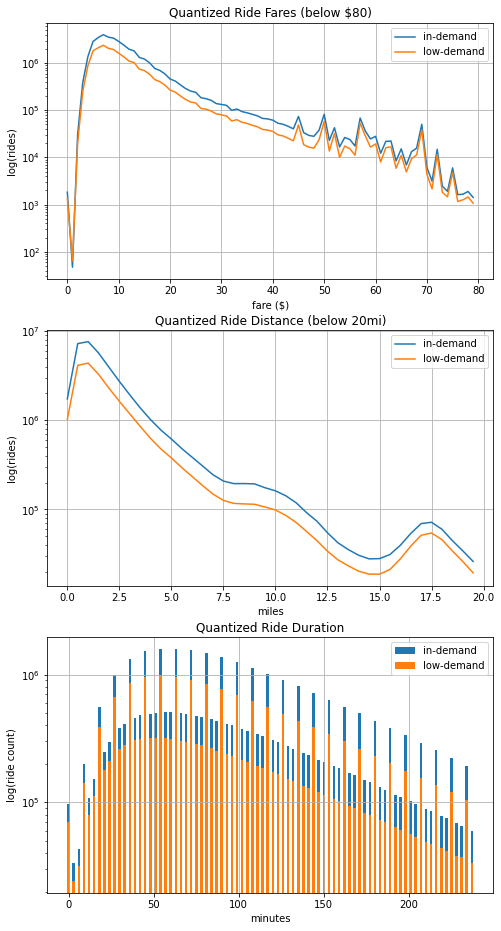

Text(0, 0.5, 'log(ride count)')

In [0]:

path_read = CREDENTIALS['paths']['nyctaxi_stats_label']

# experienced mode derivation of data (about 10-25m)
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    # here, group and count ride durations into groups of 3-minute intervals
    df_labeled_agg = (df_labeled
        .withColumn('metric', F.floor(F.col('ride_duration')/F.lit(60/3))*F.lit(3) )
        .filter((F.col('metric') < F.lit(240)) & (F.col('metric') >= F.lit(0)))
        .groupBy('metric', 'is_top').agg(F.count('metric').alias('count'))
        .withColumn('analysis', F.lit('duration'))
    )
    # here, group and count ride distances into groups of half-mile intervals (union with others)
    df_labeled_agg = (df_labeled_agg.union(df_labeled
        .withColumn('metric', F.floor(F.col('trip_distance')/F.lit(0.5))*F.lit(0.5) )
        .filter(F.col('metric') < F.lit(20))
        .groupBy('metric', 'is_top').agg(F.count('metric').alias('count'))
        .withColumn('analysis', F.lit('distance'))
    ))
    # here, group and count ride fares into groups of dollar intervals
    df_labeled_agg = (df_labeled_agg.union(df_labeled
        .withColumn('metric', F.floor(F.col('total_amount')) )
        .filter(F.col('metric') < F.lit(80))
        .groupBy('metric', 'is_top').agg(F.count('metric').alias('count'))
        .withColumn('analysis', F.lit('fare'))
    ))
    # only admins write this one (it takes almost 5m to aggregate)
    dbutils.fs.rm(path_read, True)  # no delta history, please
    df_labeled_agg.write.format('delta').save(path_read)   # save for workshop

    # also write aggregated stats by the zone
    df_zone_historical = (df_labeled
        .filter(F.col('dataset')==F.lit('test'))
        # do aggregate, but make temp copy for those in top category
        .withColumn('_top_volume', F.when(F.col('is_top')==F.lit(1), F.col('volume'))
                                   .otherwise(F.lit(0)))
        .withColumn('_top_total', F.when(F.col('is_top')==F.lit(1), F.col('total_amount'))
                                   .otherwise(F.lit(0)))
        .groupBy('pickup_zone').agg(
            F.mean(F.col('total_amount')).alias('mean_total'),
            F.mean(F.col('_top_total')).alias('mean'),
            F.sum(F.col('total_amount')).alias('sum_total'),
            F.sum(F.col('_top_total')).alias('sum'),
            F.sum(F.col('volume')).alias('volume_total'),
            F.sum(F.col('_top_volume')).alias('volume'),
        )
    )
    # clobber historical file, rewrite
    dbutils.fs.rm(CREDENTIALS['paths']['nyctaxi_h3_historical'], True)
    df_zone_historical.write.format('delta').save(CREDENTIALS['paths']['nyctaxi_h3_historical'])


df_labeled_agg = spark.read.format('delta').load(path_read)  # speed-up without heavy compute
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# straight line plot
pdf_count_dist = df_labeled_agg.filter(F.col('analysis')==F.lit('distance')).toPandas().sort_values('metric') 
pdf_valid = pdf_count_dist[pdf_count_dist['is_top']==1]
pdf_invalid = pdf_count_dist[pdf_count_dist['is_top']==0]
axes[1].plot(pdf_valid['metric'], pdf_valid['count'], label='in-demand')
axes[1].plot(pdf_invalid['metric'], pdf_invalid['count'], label='low-demand')
axes[1].semilogy()
axes[1].grid()
axes[1].legend()
axes[1].set_title('Quantized Ride Distance (below 20mi)')
axes[1].set_xlabel('miles')
axes[1].set_ylabel('log(rides)')

# straight line plot
pdf_count_fares = df_labeled_agg.filter(F.col('analysis')==F.lit('fare')).toPandas().sort_values('metric') 
pdf_valid = pdf_count_fares[pdf_count_fares['is_top']==1]
pdf_invalid = pdf_count_fares[pdf_count_fares['is_top']==0]
axes[0].plot(pdf_valid['metric'], pdf_valid['count'], label='in-demand')
axes[0].plot(pdf_invalid['metric'], pdf_invalid['count'], label='low-demand')
axes[0].semilogy()
axes[0].grid()
axes[0].legend()
axes[0].set_title('Quantized Ride Fares (below $80)')
axes[0].set_xlabel('fare ($)')
axes[0].set_ylabel('log(rides)')

# NOTE: bar plot because there are some data-caused harmonics here
pdf_count_ride = df_labeled_agg.filter(F.col('analysis')==F.lit('duration')).toPandas().sort_values('metric') 
pdf_valid = pdf_count_ride[pdf_count_ride['is_top']==1]
pdf_invalid = pdf_count_ride[pdf_count_ride['is_top']==0]
axes[2].bar(pdf_valid['metric'], pdf_valid['count'], width=1.5, linewidth=0, align='center', log=True, label='in-demand')
axes[2].bar(pdf_invalid['metric'], pdf_invalid['count'], width=1.5, linewidth=0, align='center', log=True, label='low-demand')
axes[2].legend()
axes[2].grid()
axes[2].set_title('Quantized Ride Duration')
axes[2].set_xlabel('minutes')
axes[2].set_ylabel('log(ride count)')


In [0]:
# preprocessing with simple group render (aggregate not too pad)
pdf_stat_label = (df_labeled
    .groupBy('date_trunc').agg(
        F.mean(F.col('total_amount')).alias('mean_total'),
        F.mean(F.col('total_amount') * F.col('is_top')).alias('mean_demand'),
        F.max(F.col('total_amount')).alias('max_total'),
        F.min(F.col('total_amount')).alias('min_total'),
        F.count(F.col('pickup_datetime')).alias('volume'),        
    )
)
taxi_plot_timeline(pdf_stat_label, col_value='mean_total', vol_volume='volume', col_value_extra='mean_demand')

Date Range: 2009-01-01 00:00:00 - 2016-06-30 00:00:00 (total days 2738)
Total Rides: 60932692
Avg Fare: 12.796076459193053

**Interactive Note**

... and hop back to the slides "Basic Modeling – Basic Modeling and Impact on Demographics" to follow along

### Data Check by Visualization
First, the distribution check seems accurate across fares, distanace, and duration.
Interestingly the generation distributions seem to show regular patterns (low and high spikes) 
at certain distances but this is a data-intrinsic pattern, perhaps a colleciton error that rounds
at regular time intervals (e.g. every 10 minutes?).

Second, comparing aggregate fares, we can see that we do loose some total fare counts
by dropping one quartile of rides (*comparision price*) versus the full set of data (*total price*).

# Simple Classifier

Now that we've defined the features, labels, and partitions (train, validate, test) for our dataset,
we're ready to train a model for prediction.  To keep this workshop and notebook at an approachable
level, we've hidden **a lot** of the underlying ML tricks, but that's okay because things like 
[AutoML](https://en.wikipedia.org/wiki/Automated_machine_learning) is increasingly an option to create
models from data alone.  

However, if you're curious to see what's going on, explore the script `features/modeling.py` for a full
walk through of the different functions and their use.
* [image source](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/640px-Kernel_Machine.svg.png)

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/640px-Kernel_Machine.svg.png' width='400px' title="ML Model Boundary" />


In [0]:
%run ../features/modeling

## n2.e7 mlflow for Model Tracking
Let's take a quick moment to explore a common issue in ML model development: tracking your models!

Fortunately, Databricks includes native hooks to [mlflow](https://mlflow.org/) and we use it heavily in the
model learning functions above.  

In our trained model, we'll create a simple [RandomForest classifier](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html#pyspark.ml.classification.RandomForestClassifier) using Pyspark's DataFrame-based [Mllib](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html).



In [0]:
# pull out our test data from the labeled dataset
path_read = CREDENTIALS['paths']['nyctaxi_geo_labeled']
df_labeled = spark.read.format('delta').load(path_read)
df_test = df_labeled.filter(F.col('dataset')==F.lit('test'))

# experienced mode derivation of data (about 15-25m)
#    this code will actually train a new model based on the input `list_features` using the label `col_label`
#    this code should be generic enough for you to reuse in your own 
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    col_label, list_features = taxi_train_columns()

    # comprehensive check for impact by data size
    # list_ratio_test = [0.05, 0.5, 0.8]
    list_ratio_test = [0.05]   # we tried several sample ratios and they were all about the same
    for sample_ratio in list_ratio_test:
        df_train = (
            df_labeled.filter(F.col('dataset')==F.lit('train'))
            .select(list_features+[col_label])
            .sample(sample_ratio, seed=42)
        )
        # the first line searches for best parameters (set num_folds=1 to skip the search)
        pipeline, best_hyperparam = modeling_gridsearch(df_train, col_label, num_folds=3)
        # these lines actually train the model
        best_hyperparam['training_fraction'] = sample_ratio
        run_name, df_pred = modeling_train(df_train, df_test, col_label, "taxi_popular", 
                                           pipeline, best_hyperparam, list_inputs=list_features)


In [0]:
# let's write our predictions in aggregate for the interactive viewer 
path_read = CREDENTIALS['paths']['nyctaxi_h3_learn_base']
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    # now let's actually load and execute the model on our TEST data
    df_predict = model_predict(df_test, "taxi_popular")
    # also write predicted, aggregated stats by the zone
    df_zone_predict = taxi_postproc_volumes(df_predict)
    # clobber historical file, rewrite
    dbutils.fs.rm(path_read, True)
    df_zone_predict.write.format('delta').save(path_read)

df_zone_predict = spark.read.format('delta').load(path_read)
display(df_zone_predict)

pickup_zone,mean_total,mean,sum_total,sum,volume_total,volume
Homecrest,21.548225806451615,4.070241935483871,2671.9800000000005,504.71000000000004,132,43
Corona,25.66258823529412,6.297105882352941,10906.6,2676.27,517,107
Bensonhurst West,21.247867647058825,3.046838235294118,2889.71,414.37000000000006,158,31
Newark Airport,81.45434316353888,29.89120643431635,30382.47,11149.419999999998,453,160
Douglaston,26.7875,0.558,535.75,11.16,20,2
East Concourse/Concourse Village,15.603810810810813,4.835932432432433,11546.820000000002,3578.59,1008,304
Mount Hope,16.270985221674877,4.576600985221675,3303.01,929.0500000000001,225,66
Pelham Parkway,16.641392405063293,5.800886075949367,1314.67,458.27,83,22
Marble Hill,13.808058252427184,5.391456310679611,1422.23,555.3199999999999,113,51
Rego Park,23.977885010266938,14.430071868583159,23354.46,14054.889999999998,1542,950


### Disparity Check
While we haven't done anything to combat the disparity (e.g. the difference in rides distribution versus highest population areas across demographics), we can do a sanity-check against the straight population map from notebook one.  

Not surprisingly, the only "improvements" we see are in Manhattan where the sheer volume of rides seem to have satisfied some of low-income needs --- but all others remain relatively unchanged.  The bad news is *this is indeed bias against ethnic or income minorities*.  The good news is *now we know where to fix things*.

Out[63]:

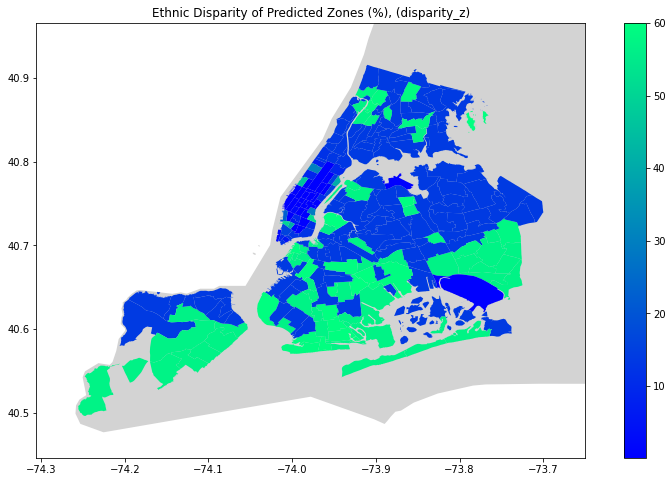

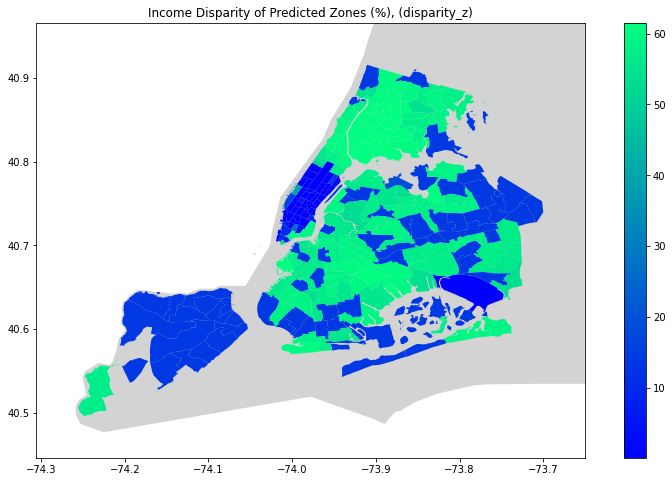

(<Figure size 1008x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Income Disparity of Predicted Zones (%), (disparity_z)'}>)

In [0]:
# reload the TOP disparity zones from notebook one
df_demo_disparity = (spark.read.format('delta').load(CREDENTIALS['paths']['demographics_disparity_base'])
    .groupBy('zone', 'factor').agg(    # group to set zones we don't care about to zero
        F.min(F.col('overall_quantile')).alias('quantile'),
        F.max(F.when(F.col('overall_quantile')==F.lit(1), F.col('cnt_zscore')).otherwise(F.lit(0))).alias('cnt_zscore'),
    )
)

# note that there is some column renaming to perform first...
row_stat_rides = df_zone_predict.select(F.mean('volume').alias('mean'), F.stddev('volume').alias('std')).collect()[0]
pdf_zone_disparity = (df_zone_predict
    .withColumnRenamed('pickup_zone', 'zone')
    .withColumn("rides_z", (F.col('volume') - F.lit(row_stat_rides['mean']))/F.lit(row_stat_rides['std']))
    .withColumnRenamed('volume', 'rides')
    .select('zone', 'rides', 'rides_z')   # get simple rides, zones, rides_z
    .join(df_demo_disparity, ['zone'])   # join with demos
    .join(spark.read.format('delta').load(CREDENTIALS['paths']['geometry_nyctaxi'])  # add shape data
          .select('zone', 'the_geom'), ['zone'])
    .withColumnRenamed('the_geom', 'geometry')
    .toPandas()
)
# NOTE: This isn't an actual volume disparity because demographics are normalized by zone
#       and ride volumes are normalized across the entire system.
pdf_zone_disparity['disparity_z'] = delta_zscore_pandas(    # safer diff compute in z-domain
    pdf_zone_disparity['cnt_zscore'], pdf_zone_disparity['rides_z'])

# load geometry for plotting
pdf_zone_disparity['geometry'] = pdf_zone_disparity['geometry'].apply(lambda x: wkt.loads(x))

# load geometry for NEW YORK state; convert to geometry presentation format
pdf_shape_states = (spark.read.format('delta').load(CREDENTIALS['paths']['geometry_state'])
    .filter(F.col('stusps')==F.lit('NY'))
    .toPandas()
)
pdf_shape_states['geometry'] = pdf_shape_states['geometry'].apply(lambda x: wkt.loads(x))

# plot the new zone + disparity
shape_plot_map(pdf_zone_disparity[pdf_zone_disparity['factor']=='ethnc_grp'], 
               col_viz='disparity_z', gdf_background=pdf_shape_states, zscore=True,
               txt_title=f"Ethnic Disparity of Predicted Zones (%)")
# plot the new zone + disparity
shape_plot_map(pdf_zone_disparity[pdf_zone_disparity['factor']=='hshld_incme_grp'], 
               col_viz='disparity_z', gdf_background=pdf_shape_states, zscore=True,
               txt_title=f"Income Disparity of Predicted Zones (%)")

# Wrap-up
That's it for this notebook for learning model building, what did we learn?

* One of the largest challenges in identifying bias in your model is understanding how it applies to your goals.
* We created a predictor that aims to emulate historical ride distributions, but now we have a way to steer those predictions.
* Due to the lack of granularity in our demographic data (no variance for population by time-of-day), we 
  totally drop the day-part of our ride predictor model and just focus on zones.
  * **NOTE**: Keeping your stakeholders informed with tough news is part of the job, even when the answer is
    "We just don't have the data to know."

Let's check out ways to improve a model with external data.  The next notebook, proceed to the **03_fairness_modeling** demonstrates techniques using external (or auxiliary data) to do the job.


**Interactive Note**

... and hop back to the slides "Cautionary Examples Understanding Bias in Data" to follow along